##  Surviving the zombie apocalypse
<br/>
Welcome to this notebook. We will present through it our submission for the challenge 2 : "Surviving the zombie apocalypse". I hope you will enjoy read this.
<br/>
<br/>


### Summary 


- preprocessing the data 

- building the first epidemic model

- Finding optimum nodes to stop the epidemic (1)

- Finding optimum nodes to stop the epidemic (2)

#### Preprocessing the data
<br/>
The epidemic started in the turkish town Rize. We want to build a model of propagation in Europe knowing the way the Zombies move and infect other life being. 
<br/>
<br/>
To this end we will use two maps giving us the population density in Europe and the elevation of the lands. 

In [1]:
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

# the path to the data
filename_elevation=r"C:\Users\luthe\Documents\IMT\S4B2\Théorie des graphes\Zombie\elevation_map.bmp"
filename_density=r"C:/Users/luthe/Documents/IMT/S4B2/Théorie des graphes/Zombie/population_map.bmp"

#the maps already have been modified in order to be exactly to the same dimensions (with photoshop)
im_elevation = Image.open(filename_elevation)
im_density = Image.open(filename_density)

im_elevation.show()
im_density.show()

In [6]:
"""We want to have two arrays : - one with the human per pixel
                                - one with the land's height per pixel
                                
                                
___________________________________________Density ____________________________________________________
"""
im_density_gray=im_density.convert('L')
p_density = np.array(im_density_gray)/255.0 #linear scale : 1=3000 humans, 0=nobody

#the height and the width of the two maps are the same 
height=p_density.shape[0]
width=p_density.shape[1]

#we build the array containing the humans per pixel
#i reduced it in order to have 500 millions of humans in Europe
p_human=np.zeros((height,width))
for y in tqdm(range(height)):
    for x in range(width):
        if p_density[y,x]>=0.1:
            p_human[y,x]=int(p_density[y,x]*300)
        else :
            p_human[y,x]=0



print('array with humans built')
        
""" ___________________________________________Elevation ___________________________________________"""

p_rgb = np.array(im_elevation) 

#to build an array containing the level (in meter) of each pixel we need to define a few functions
def is_blue(pix):
    """ 
    Return True if pix is a blue pix (sea) 
    """
    return pix[0]<50 and pix[1]>150 and pix[1]<200 and pix[2]==255

#we build a the mean value of the blue pixel (it will be use as a treshold for our 0 in the linear
#scale we will build to convert  RGB in color)
mean_blue=[0,0,0]
count=0
for y in tqdm(range(height)):
    for x in range(width):
        if is_blue(p_rgb[y,x]):
            count+=1
            mean_blue[0]+=p_rgb[y,x,0]
            mean_blue[1]+=p_rgb[y,x,1]
            mean_blue[2]+=p_rgb[y,x,2]
mean_blue=np.array(np.array(mean_blue)/count,dtype='int')
print('mean val of blue pixel computed')

#we need to find the heighest pixel (Mont Blanc=4810m) in order to obtain a second reference to our scale
max_pix=0
idx=0
p_sum=p_rgb.sum(axis=2)
for y in tqdm(range(height)):
    for x in range(width):
        if p_sum[y,x]>max_pix:
            max_pix=p_sum[y,x]
            idx=(y,x)
            
print('heighest pixel found')

def pix_elevation(pix):
    """
    return the level of the pixel according to its RGB color on the map
    """
    if is_blue(pix):
        return 0
    else : 
        #max_pix is the sum of the RGB values of the Mont Blanc
        #and we smooth a little the elevation 
        return (np.exp(-1+(pix.sum()-mean_blue.sum())/(max_pix-mean_blue.sum())))*481
        #return (np.exp((pix.sum()-mean_blue.sum())/(max_pix-mean_blue.sum()))-1)*481

#and now we build our array
p_elevation=np.zeros((height,width))
for y in tqdm(range(height)):
    for x in range(width):
        p_elevation[y,x]=pix_elevation(p_rgb[y,x])
print('array with altitudes built')

  0%|                                                                                         | 0/2860 [00:00<?, ?it/s]

array with humans built


100%|██████████████████████████████████████████████████████████████████████████████| 2860/2860 [01:54<00:00, 24.92it/s]


mean val of blue pixel computed


  0%|                                                                                 | 1/2860 [00:00<06:02,  7.88it/s]

heighest pixel found


100%|██████████████████████████████████████████████████████████████████████████████| 2860/2860 [06:22<00:00,  7.48it/s]

array with altitudes built


#### Building the model
<br/>
In order to simulate the propagation of the epidemic we will create a graph where each cell is a nodes. A node will have eight or less linked nodes (the eight neighboring cells if the slope between two cell is not to high) and will have two attributes : the number of zombie and the number of humans. 
<br/>
<br/>
To get rid of useless calcul we will delete the edge where the slope between two cells is too high

In [20]:
#useful functions
Rize_cell, Brest_cell=0,0

def build_cell(nbre_pix_height=20, nbre_pix_width=20, height=2860, width=4490):
    global Rize_cell, Brest_cell
    """
    function that build the cell and return a dic where the keys are the cells
    and the object are the pixels inside the cell
    """
    cell=dict()
    cell_count=0
    for y in tqdm(range(0,height,nbre_pix_height)):
        for x in range(0,width, nbre_pix_width):
            if (y+nbre_pix_height>=1306 and x+nbre_pix_width>=669) and (y<1306 and x<669):
                print('Rize town {}'.format(cell_count))
                Rize_cell='U'+str(cell_count)
            if (y+nbre_pix_height>=2108 and x+nbre_pix_width>=4426) and (y<2108 and x<4426):
                print('Brest town {}'.format(cell_count))
                Brest_cell='U'+str(cell_count)
            if x+nbre_pix_width-width>0:
                if y+nbre_pix_height-height>0:
                    cell['U'+str(cell_count)]=[(y+i,x+j)for i in range(y+nbre_pix_height-height) for j in range(x+nbre_pix_width-width)]
                else:
                    cell['U'+str(cell_count)]=[(y+i,x+j)for i in range(nbre_pix_height) for j in range(x+nbre_pix_width-width)]
            elif y+nbre_pix_height-height>0:
                cell['U'+str(cell_count)]=[(y+i,x+j)for i in range(y+nbre_pix_height-height) for j in range(nbre_pix_width)]
            else:
                cell['U'+str(cell_count)]=[(y+i,x+j)for i in range(nbre_pix_height) for j in range(nbre_pix_width)]
            cell_count+=1
    print("cells built")
    return cell

def around_cell(cell, nbre_pix_height=20, nbre_pix_width=20, height=2860, width=4490):
    """
    return the neighboring cells of a cell
    """
    width_map=math.ceil(width/nbre_pix_width)#on prend l'arrondi supérieur
    size_map=width_map*math.ceil(height/nbre_pix_height)
    num_cell=int(cell[1:])
    res=[num_cell-1,num_cell+1,num_cell-224,num_cell+224,num_cell-225,num_cell+225, num_cell-226, num_cell+226]
    final_res=[]
    if num_cell%width_map==0: #Si on est sur le côté gauche
        res.remove(num_cell-1)
        res.remove(num_cell-226)
        res.remove(num_cell+224)
    if num_cell%width_map==width_map-1:#si on est sur le côté droit
        res.remove(num_cell+1)
        res.remove(num_cell-224)
        res.remove(num_cell+226)
    if num_cell<225: #si on est sur la première ligne
        if num_cell%width_map!=0: #Si on est pas sur le côté gauche
            res.remove(num_cell-226)
        res.remove(num_cell-225)
        if num_cell%width_map!=width_map-1: #Si on est pas sur le côté droit
            res.remove(num_cell-224)
    if num_cell>=size_map-225: #si on est sur la dernière ligne
        if num_cell%width_map!=0: #Si on est pas sur le côté gauche
            res.remove(num_cell+224)
        res.remove(num_cell+225)
        if num_cell%width_map!=width_map-1: #Si on est pas sur le côté droit
            res.remove(num_cell+226)
    for node in res:
        final_res.append('U'+str(node))
    return final_res

def build_edges(node):
    """
    return the edges to build from a node
    """
    res=[]
    for neighbor in around_cell(node):
        if Europe_attribute[neighbor][0]!=0 and (np.arctan(abs(Europe_attribute[neighbor][0]-Europe_attribute[node][0])/500)*180/np.pi):
            res.append(neighbor)
    return res

"""__________________________________________Building the Graph_____________________________________"""

import networkx as nx
#we build the cell
cells=build_cell()
Europe_attribute=dict()#a dict that will contain the level and the humans for each node

for node in tqdm(cells.keys()):
    cell_attrib_hum=0
    cell_attrib_elevation=0
    cell_attrib_zom=0
    for pix in cells[node]:
        cell_attrib_elevation+=p_elevation[pix]
        cell_attrib_hum+=p_human[pix]
    Europe_attribute[node]=(cell_attrib_elevation/len(cells[node]),cell_attrib_hum, cell_attrib_zom)
    
Rize_pop=94800 #https://fr.wikipedia.org/wiki/Rize
Rize_elevation=200
Europe_attribute[Rize_cell] = (Rize_elevation, 0, Rize_pop)

print("Europe attribute built")
#the graph
Zombie_Graph=nx.Graph()
Zombie_Graph.clear()

for node in Europe_attribute.keys():
    Zombie_Graph.add_node(node)
    

for node in Zombie_Graph.nodes():
    for linked_node in build_edges(node):
        if not(Zombie_Graph.has_edge(node, linked_node)):
            Zombie_Graph.add_edge(node, linked_node)
            
#last but not least, as we know that island such as Great Britain are protected, we delete them from 
#the graph, we also delete all the nodes of sea unuseful because they have no neighbor and
#we create a Day_0 dict that will be the same as Europe_Attribute but without de unnecessary nodes
comps = sorted(nx.connected_components(Zombie_Graph), key=len, reverse=True)
nodes_in_giant_comp = comps[0]
Zombie_Graph = nx.subgraph(Zombie_Graph, nodes_in_giant_comp)
Day_0=dict()
for node in Zombie_Graph.nodes():
    Day_0[node]=Europe_attribute[node]
print("Graph built")

 48%|██████████████████████████████████████▌                                          | 68/143 [00:02<00:02, 27.30it/s]

Rize town 14658


 75%|███████████████████████████████████████████████████████████▊                    | 107/143 [00:03<00:01, 29.36it/s]

Brest town 23846


  1%|▍                                                                           | 194/32175 [00:00<00:17, 1866.04it/s]

cells built


100%|██████████████████████████████████████████████████████████████████████████| 32175/32175 [00:21<00:00, 1515.88it/s]


Europe attribute built
Graph built


Now we have the Graph with the edges, and we want to simulate the Zombie propagation through Europe. To this end, we're gonna build a dictionnary for each days that'll have the same form as Europe_attribute. But before that, let's define some functions.

In [21]:
def slope_factor(cell_1,cell_2):
    """
    Return the slope factor between two cells
    """
    degree=np.arctan(abs(Europe_attribute[cell_1][0]-Europe_attribute[cell_2][0])/500)*180/np.pi
    if degree>=10:
        return 0
    else : 
        return (-1*degree/10)+1

def Contribution(cell_1, cell_2, Current_day_info, Graph):
    """
    Return the Contribution of cell_1 to cell_2 at the day given by Current_day
    (the info dict of the day)
    """
    sum_hum=0
    for neighbor in Graph.neighbors(cell_1):
        sum_hum+=Current_day_info[neighbor][1]
    if cell_1==cell_2:
        if sum_hum==0:
            return Current_day_info[cell_1][2]
        else:
            return 0
    if not(cell_2 in Graph.neighbors(cell_1)):
        print("The cells given in Contribution arn't neighbor")
        return 0
    if sum_hum>0:
        return int(Current_day_info[cell_2][1]*slope_factor(cell_1,cell_2)*Current_day_info[cell_1][2]/sum_hum)
    if sum_hum==0:
        return 0

def step_1(Current_day_info, Graph):
    """
    Return a dict of all cells and the linked contribution sum
    """
    res=dict()
    for node in Graph.nodes():
        sum_contrib=Contribution(node, node, Current_day_info, Graph)
        for neighbor in Graph.neighbors(node):
            sum_contrib+=Contribution(neighbor, node, Current_day_info, Graph)
        res[node]=sum_contrib
    return res

def step_2_3(Current_day_info, New_Zombie_dict, Graph, past_15_data=None):
    """
    Input : the info of the day, the dict create by step1, the info of the day 15 before
    (if None we don't kill old zombies) and the graph
    Output : the Next_day_info
    
    *Zombies will die after 15 days we simply subtract the quantity of zombies
    that were there 15 days before in the same cell 
    """
    Next_day_info=dict()
    #step 2 : every Zombies kill 10 humans (that became zombies)
    #step 3 : every humans still alive kill 10 Zombies and the oldest Zombies die
    for cell in Current_day_info.keys():
        nb_human_left=Current_day_info[cell][1]-(10*New_Zombie_dict[cell])
        if nb_human_left<=0:
            Next_day_info[cell]=(Current_day_info[cell][0],0,Current_day_info[cell][1]+New_Zombie_dict[cell])
        else : #nb_human_left>0
            new_zombie_pop=New_Zombie_dict[cell]-(nb_human_left*10)
            if new_zombie_pop>0:
                 Next_day_info[cell]=(Current_day_info[cell][0],nb_human_left,new_zombie_pop)
            else :
                Next_day_info[cell]=(Current_day_info[cell][0],nb_human_left,0)
        if not(past_15_data is None) and Next_day_info[cell][2]>0:
            Next_day_info[cell]=(Next_day_info[cell][0],Next_day_info[cell][1], np.max([0,Next_day_info[cell][2]-past_15_data[cell][2]]))
    return Next_day_info
            

def simulate_propagation(Graph, Europe_initial_state):
    """
    Inputs : Graph is a networkx graph that we'll use to simulate the advancement of the Zombies
             Europe_initial_state is a dict that will serve as "day 0"
    Outputs : The list of the dict for every day in the zombies epidemic
    """
    day=0 #to count the days throught
    Info_days=[0,Europe_initial_state] #In Info_days we will append a dictionary per day
    
    #while we don't reach a convergence point or we surpass 500 days we simulate
    while Info_days[-1]!=Info_days[-2] or day>500:
        step1=step_1(Info_days[-1],Graph)
        if len(Info_days)<17:
            new_day=step_2_3(Info_days[-1], step1, Graph)
        else: #we reach the 15th day so old zombies start to die
            new_day=step_2_3(Info_days[-1], step1, Graph, Info_days[-15])
        Info_days.append(new_day)
        day+=1
        print("day {}".format(day))
    return Info_days

In [22]:
First_simulation=simulate_propagation(Zombie_Graph, Day_0)

day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99
day 100
day 101
day 102
day 103
day 104
day 105
day 106
day 107
day 108
day 109
day 110
day 111
day 112
day 113
day 114
day 115
day 116
day 117
day 118
day 119
day 120
day 121
day 122
day 123
day 124
day 125
day 126
day 127
day 128
day 129
day 130
day 131
day 132
day 133
day 134
day 135
day 136
day 137
day 138
day 

In [23]:
print('number of zombies at Brest on day 187 : {}'.format(First_simulation[188][Brest_cell][2]))
print('number of zombies at Brest on day 188 : {}'.format(First_simulation[189][Brest_cell][2]))

number of zombies at Brest on day 187 : 0
number of zombies at Brest on day 188 : 96770.0


In [24]:
survivors=0
for node in First_simulation[-1].keys():
    survivors+=First_simulation[-1][node][1]
loss=p_human.sum()-survivors #important var that we will use for our metric
print('number of human still alive : {}'.format(survivors))
print ('number of human killed : {}'.format(loss))

number of human still alive : 68929483.0
number of human killed : 433668615.0


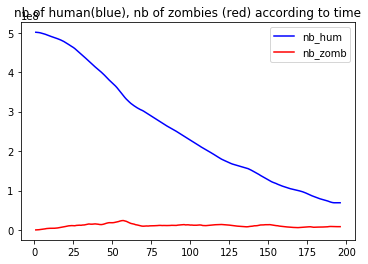

In [25]:
x_days=[i for i in range(1,197)]
y_hum=[0 for i in range(1,197)]
y_zomb=[0 for i in range(1,197)]
for day in x_days:
    for node in First_simulation[day]:
        y_hum[day-1]+=First_simulation[day][node][1]
        y_zomb[day-1]+=First_simulation[day][node][2]
plt.plot(x_days,y_hum, c='b', label='nb_hum')
plt.plot(x_days,y_zomb, c='r', label='nb_zomb')
plt.legend()
plt.title('nb of human(blue), nb of zombies (red) according to time')
plt.show()

#### Conclusion of first part :
<br/>
The model works, almost all human in Europe died. A little part survived (it should be a place that Zombies couldn't reach). The Zombies reach Brest on day 187 and kill all the population of the city.

### Stop the epidemic : with soldiers
<br/>
After 60 days we're able to protect 20 cells, let's find which cells will protect the maximum people.

In [43]:
def metric(Last_day_simulated, First_day_simulated):
    global loss
    """
    Input : the last day simulated and the first day simulated
    Our metric for this question is the rapport between the number of human killed in our new simulation
    and the number of human killed if we had done nothing (from the day we start the solution)
    the goal is to minimize this number
    """
    survivor=0
    loss_before_beginning_of_sol=0
    for node in First_day_simulated.keys():
        loss_before_beginning_of_sol+=First_day_simulated[node][1]
    loss_before_beginning_of_sol=p_human.sum()-loss_before_beginning_of_sol
    
    for node in Last_day_simulated.keys():
        survivor+=Last_day_simulated[node][1]
    return (p_human.sum()-survivor-loss_before_beginning_of_sol)/(loss-loss_before_beginning_of_sol)

def stat_simulation(result_simulation):
    global loss
    """
    this function print some stats on a simulation
    """
    nb_days=len(result_simulation)
    
    #first, have zombies reach Brest ?
    if result_simulation[-1][Brest_cell][1]!=0:
        print('Brest pop survived')
    else : 
        for i in range(1,nb_days):
            if result_simulation[-1*i][Brest_cell][1]!=0:
                day=nb_days-i
                print('number of humans at Brest on day {} : {}'.format(day,result_simulation[day][Brest_cell][1]))
                print('number of humans at Brest on day {} : {}'.format(day+1,result_simulation[day+1][Brest_cell][1]))
                break
                
    #now the number of human killed, the survivors and the metric
    survivors=0
    for node in result_simulation[-1].keys():
        survivors+=result_simulation[-1][node][1]
    simulation_loss=p_human.sum()-survivors
    print('number of human still alive : {}'.format(survivors))
    print ('number of human killed : {}'.format(loss))
    print('ratio from the first simulation : {}'.format(metric(result_simulation[-1], result_simulation[1])))
    
    #now we print the number of human per days and the number of zombies
    x_days=[i for i in range(1,nb_days)]
    y_hum=[0 for i in range(1,nb_days)]
    y_zomb=[0 for i in range(1,nb_days)]
    for day in x_days:
        for node in result_simulation[day]:
            y_hum[day-1]+=result_simulation[day][node][1]
            y_zomb[day-1]+=result_simulation[day][node][2]
    plt.plot(x_days,y_hum, c='b', label='nb_hum')
    plt.plot(x_days,y_zomb, c='r', label='nb_zomb')
    plt.legend()
    plt.title('nb of human(blue), nb of zombies (red) according to time')
    pass
    

In [27]:
#first let's try to eliminate the 20 cells where there is the most zombie (if there are humans in 
#the neighboring cells)
Day_60=First_simulation[61] #we start to search our 20 cells here
most_zomb_node=[]
nb_zombie=0

while len(most_zomb_node)<20:
    for node in Day_60.keys():
        if Day_60[node][2]>nb_zombie and not(node in most_zomb_node):
            max_current_node=node
    most_zomb_node.append(max_current_node)
#we print the number of humans around the cells with the most zombies
for node in most_zomb_node:
    nb_human_around=0
    for neighbor in Zombie_Graph.neighbors(node):
        nb_human_around+=Day_60[neighbor][1]
    print('number of human around the cell {} : {} (with {} zombies in the cell)'.format(node,nb_human_around,Day_60[node][2]))

number of human around the cell U28160 : 26656.0 (with 36845.0 zombies in the cell)
number of human around the cell U28159 : 38049.0 (with 72975.0 zombies in the cell)
number of human around the cell U28158 : 68122.0 (with 27915.0 zombies in the cell)
number of human around the cell U28157 : 57290.0 (with 19026.0 zombies in the cell)
number of human around the cell U28156 : 44157.0 (with 16745.0 zombies in the cell)
number of human around the cell U28155 : 36891.0 (with 100658.0 zombies in the cell)
number of human around the cell U28154 : 49287.0 (with 63750.0 zombies in the cell)
number of human around the cell U28153 : 65240.0 (with 58931.0 zombies in the cell)
number of human around the cell U28152 : 88528.0 (with 70644.0 zombies in the cell)
number of human around the cell U28151 : 93705.0 (with 50700.0 zombies in the cell)
number of human around the cell U28150 : 90790.0 (with 47523.0 zombies in the cell)
number of human around the cell U28149 : 67892.0 (with 39787.0 zombies in t

In [28]:
#now let's try a second simulation starting Day_60 with a graph where we have changed the cells above
Zombie_Graph_with_soldier=Zombie_Graph.copy()
for node in most_zomb_node:
    for neighbor in Zombie_Graph.neighbors(node):
        if Zombie_Graph_with_soldier.has_edge(node, neighbor) :
            Zombie_Graph_with_soldier.remove_edge(node, neighbor)
    Day_60[node]=(Day_60[node][0], Day_60[node][1], 0)
    
#and let's go for the second simulation
Second_simulation=simulate_propagation(Zombie_Graph_with_soldier, Day_60)

day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99
day 100
day 101
day 102
day 103
day 104
day 105
day 106
day 107
day 108
day 109
day 110
day 111
day 112
day 113
day 114
day 115
day 116
day 117
day 118
day 119
day 120
day 121
day 122
day 123
day 124
day 125
day 126
day 127
day 128
day 129
day 130
day 131
day 132
day 133
day 134
day 135


number of humans at Brest on day 128 : 9487.0
number of humans at Brest on day 129 : 0
number of human still alive : 68973616.0
number of human killed : 433668615.0
ratio from the first simulation : 0.9998269828869442


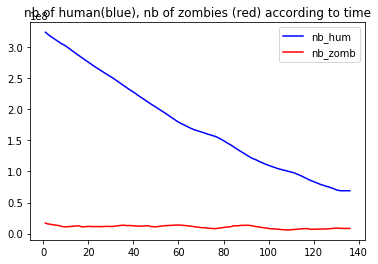

In [44]:
stat_simulation(Second_simulation)

This works not at all, let's try a better solution. We are going to try to calculate the betweenness but as the Graph is big, we're going to approximate betweenness values

In [30]:
approximate_betweenness=nx.betweenness_centrality(Zombie_Graph, k=200)
#the value k is the number of sample used to calcul the betweenness

In [31]:
#let's find the 20 cells with the highest betweenness that hasnt been reach by zombies (there is still humans)
Day_60=First_simulation[61] #we start to search our 20 cells here
most_betweenness_nodes=[]
betweenness=0

while len(most_betweenness_nodes)<20:
    for node in Day_60.keys():
        if approximate_betweenness[node]>betweenness and not(node in most_betweenness_nodes) and Day_60[node][1]>0:
            better_current_node=node
    most_betweenness_nodes.append(better_current_node)

for node in most_betweenness_nodes:
    nb_human_around=0
    for neighbor in Zombie_Graph.neighbors(node):
        nb_human_around+=Day_60[neighbor][1]
    print('number of human around the cell {} of betweenness {} : {} (with {} zombies in the cell)'.format(node,approximate_betweenness[node],nb_human_around,Day_60[node][2]))

number of human around the cell U32164 of betweenness 1.2262430490663645e-05 : 1614.0 (with 0 zombies in the cell)
number of human around the cell U32163 of betweenness 1.0839864284710417e-05 : 10157.0 (with 0 zombies in the cell)
number of human around the cell U32162 of betweenness 9.256940357521418e-06 : 8322.0 (with 0 zombies in the cell)
number of human around the cell U32161 of betweenness 7.522695242465226e-06 : 11685.0 (with 0 zombies in the cell)
number of human around the cell U32160 of betweenness 5.663298688091575e-06 : 8084.0 (with 0 zombies in the cell)
number of human around the cell U32159 of betweenness 3.658221809200479e-06 : 4458.0 (with 0 zombies in the cell)
number of human around the cell U32158 of betweenness 1.4251992445798863e-06 : 15614.0 (with 0 zombies in the cell)
number of human around the cell U32157 of betweenness 1.6310994665563667e-06 : 47553.0 (with 0 zombies in the cell)
number of human around the cell U32156 of betweenness 1.8877344632963617e-06 : 1

In [32]:
#now let's try a third simulation starting Day_60 with a graph where we have changed the cells above
Zombie_Graph_with_soldier=Zombie_Graph.copy()
for node in most_betweenness_nodes:
    for neighbor in Zombie_Graph.neighbors(node):
        if Zombie_Graph_with_soldier.has_edge(node, neighbor) :
            Zombie_Graph_with_soldier.remove_edge(node, neighbor)
    Day_60[node]=(Day_60[node][0], Day_60[node][1], 0)
    
#and let's go for the second simulation
Third_simulation=simulate_propagation(Zombie_Graph_with_soldier, Day_60)

day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99
day 100
day 101
day 102
day 103
day 104
day 105
day 106
day 107
day 108
day 109
day 110
day 111
day 112
day 113
day 114
day 115
day 116
day 117
day 118
day 119
day 120
day 121
day 122
day 123
day 124
day 125
day 126
day 127
day 128
day 129
day 130
day 131
day 132
day 133
day 134
day 135


number of humans at Brest on day 128 : 9487.0
number of humans at Brest on day 129 : 0
number of human still alive : 69229974.0
number of human killed : 433668615.0
ratio from the first simulation : 0.998821968021225


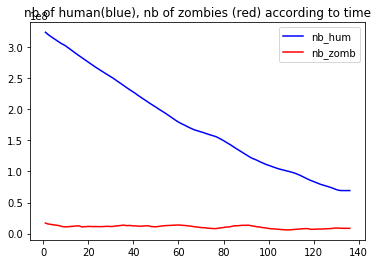

In [45]:
stat_simulation(Third_simulation)

This try works a little better according to the metrics but it's clearly not satisfying, it might be because at 60 days the epidemic is too advanced.
<br/>
<br/>
Another reason is that once the soldier secured a cell, the zombie won't try to go trough it anymore. However if we secure cells with lots of human the zombies will still be attract by the cell and will be kill by the soldier.
<br/>
Let's modify our algorithm of simulation to test this hypothesis.

In [34]:
def modified_simulate_propagation(Graph, Europe_initial_state, special_cells):
    """
    Inputs : Graph is a networkx graph that we'll use to simulate the advancement of the Zombies
             Europe_initial_state is a dict that will serve as "day 0"
    Outputs : The list of the dict for every day in the zombies epidemic
    *this function has been modified in order to be able to create cells that still attract zombies
    but kill them automatically
    """
    day=0 #to count the days throught
    Info_days=[0,Europe_initial_state] #In Info_days we will append a dictionary per day
    
    #while we don't reach a convergence point or we surpass 500 days we simulate
    while Info_days[-1]!=Info_days[-2] or day>500:
        step1=step_1(Info_days[-1],Graph)
        if len(Info_days)<17:
            new_day=step_2_3(Info_days[-1], step1, Graph)
        else: #we reach the 15th day so old zombies start to die
            new_day=step_2_3(Info_days[-1], step1, Graph, Info_days[-15])
        #we kill the zombies attracted in the special cells
        for node in special_cells:
            new_day[node]=(new_day[node][0], Info_days[1][node][1], 0)
        Info_days.append(new_day)
        day+=1
        print("day {}".format(day))
    return Info_days

In [35]:
#Now we need to select the nodes with the highest number of humans
Day_60=First_simulation[61] #we start to search our 20 cells here
most_hum_node=[]
nb_hum=0

while len(most_hum_node)<20:
    for node in Day_60.keys():
        if Day_60[node][1]>nb_hum and not(node in most_hum_node):
            max_current_node=node
    most_hum_node.append(max_current_node)

for node in most_hum_node:
    print('number of human in the cell {} : {} (with {} betweenness)'.format(node,Day_60[node][1],approximate_betweenness[node]))

number of human in the cell U32174 : 8677.0 (with 0.0 betweenness)
number of human in the cell U32164 : 496.0 (with 1.2262430490663645e-05 betweenness)
number of human in the cell U32163 : 454.0 (with 1.0839864284710417e-05 betweenness)
number of human in the cell U32162 : 4980.0 (with 9.256940357521418e-06 betweenness)
number of human in the cell U32161 : 2912.0 (with 7.522695242465226e-06 betweenness)
number of human in the cell U32160 : 1111.0 (with 5.663298688091575e-06 betweenness)
number of human in the cell U32159 : 3099.0 (with 3.658221809200479e-06 betweenness)
number of human in the cell U32158 : 1157.0 (with 1.4251992445798863e-06 betweenness)
number of human in the cell U32157 : 2587.0 (with 1.6310994665563667e-06 betweenness)
number of human in the cell U32156 : 15042.0 (with 1.8877344632963617e-06 betweenness)
number of human in the cell U32155 : 30788.0 (with 2.2376647330085636e-06 betweenness)
number of human in the cell U32154 : 24321.0 (with 2.6502832513640084e-06 bet

In [36]:
#and now we simulate while protecting this 20 cells
Fourth_simulation=modified_simulate_propagation(Zombie_Graph, Day_60, most_hum_node)

day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99
day 100
day 101
day 102
day 103
day 104
day 105
day 106
day 107
day 108
day 109
day 110
day 111
day 112
day 113
day 114
day 115
day 116
day 117
day 118
day 119
day 120
day 121
day 122
day 123
day 124
day 125
day 126
day 127
day 128
day 129
day 130
day 131
day 132
day 133
day 134
day 135


number of humans at Brest on day 128 : 9487.0
number of humans at Brest on day 129 : 0
number of human still alive : 69238651.0
number of human killed : 433668615.0
ratio from the first simulation : 0.9992870869846092


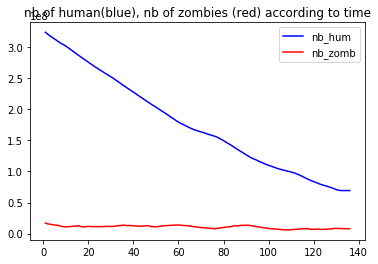

In [37]:
stat_simulation(Fourth_simulation)

It didn't work well too, it might be because the soldiers act too late to contain the epidemic. Let's move on the last solution to save humanity: Nuclear bomb !!
<br/>
<br/>
<br/>
### Stop the epidemic : with Nuclear bombs
<br/>
we are now 120 days after the start of the epidemic. Most of Europe has been destroyed by zombies and our last hope is a series of nuclear attack.

In [38]:
#A first very extrem solution is to hit all the cells with zombies (with 
# at least 1000 humans in the neighboring cells)
Day_120=First_simulation[121]
cell_with_zombies=[]
for node in Zombie_Graph.nodes():
    if Day_120[node][2]>0 and approximate_betweenness[node]>0.001:
        nb_hum_around=0
        for neighbor in Zombie_Graph.neighbors(node):
            nb_hum_around+=Day_120[neighbor][1]
        if nb_hum_around>1000:
            cell_with_zombies.append(node)

In [39]:
#now let's try a simulation starting Day_120 with a graph where we have changed the cells above
Zombie_Graph_with_bomb=Zombie_Graph.copy()
for node in cell_with_zombies:
    for neighbor in Zombie_Graph.neighbors(node):
        if Zombie_Graph_with_bomb.has_edge(node, neighbor) :
            Zombie_Graph_with_bomb.remove_edge(node, neighbor)
    Day_120[node]=(Day_120[node][0], 0, 0)

#and let's go for the simulation
Fifth_simulation=simulate_propagation(Zombie_Graph_with_bomb, Day_120)    

day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99
day 100
day 101
day 102
day 103
day 104
day 105
day 106
day 107
day 108
day 109
day 110
day 111
day 112
day 113
day 114
day 115
day 116
day 117
day 118
day 119
day 120
day 121
day 122
day 123
day 124
day 125
day 126
day 127
day 128
day 129
day 130
day 131
day 132
day 133
day 134
day 135
day 136
day 137
day 138
day 

number of humans at Brest on day 102 : 9487.0
number of humans at Brest on day 103 : 0
number of human still alive : 68971967.0
number of human killed : 433668615.0
ratio from the first simulation : 0.9996085331769284


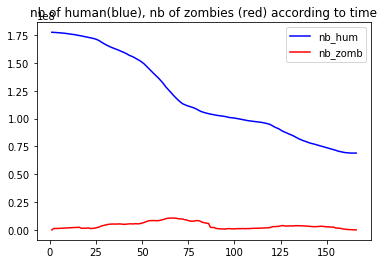

In [46]:
stat_simulation(Fifth_simulation)

In [41]:
#and if we just destroy all zombies ?
Day_120=First_simulation[121]
cell_with_zombies=[]
for node in Zombie_Graph.nodes():
    if Day_120[node][2]>0 :
        cell_with_zombies.append(node)
        
#now let's try a simulation starting Day_120 with a graph where we have changed the cells above
Zombie_Graph_with_bomb=Zombie_Graph.copy()
for node in cell_with_zombies:
    for neighbor in Zombie_Graph.neighbors(node):
        if Zombie_Graph_with_bomb.has_edge(node, neighbor) :
            Zombie_Graph_with_bomb.remove_edge(node, neighbor)
    Day_120[node]=(Day_120[node][0], 0, 0)

#and let's go for the simulation
Sixth_simulation=simulate_propagation(Zombie_Graph_with_bomb, Day_120)    

day 1


Brest pop survived
number of human still alive : 177454644.0
number of human killed : 433668615.0
ratio from the first simulation : 0.0


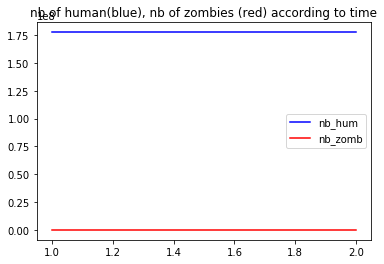

In [47]:
stat_simulation(Sixth_simulation)

I have the feeling that whatever we do, 120 days is too advanced to modify the result and block the zombies. As we can observ above, the metric reach 0 when we kill all zombies with bombs (there is no humans killed by the bombs because they already have been eaten by the zombies on the concerned cells).